In [1]:
import cftime
import fsspec
import numpy as np
import xarray as xr
import yaml
import matplotlib.pyplot as plt
import string
from datetime import timedelta

import vcm
plt.rcParams['figure.dpi'] = 200

In [2]:
with open('run_urls.yaml') as f:
    runs = yaml.safe_load(f)

### Open pre-computed diagnostics to plot zonal mean biases

In [3]:
urls_long = {
    "baseline": runs['baseline-35day']['url'],
    "ML-physics (seed-5)": runs['prog-35day-seed5']['url'],
    "ML-physics (seed-7)": runs['prog-35day-seed7']['url'],
    "nudge-to-fine": runs['n2f-35day']['url'],
}
verif_url = 'gs://vcm-ml-experiments/default/2021-12-16/2020-05-27-40-day-X-SHiELD-simulation-v2/fine-res-budget.zarr'

In [4]:
fs = fsspec.filesystem('gs')
reduced_diags = []
for name, url in urls_long.items():
    tmp = vcm.open_remote_nc(fs, url+'_diagnostics/diags.nc')
    reduced_diags.append(tmp.assign_coords(run=name))
reduced_diags = xr.concat(reduced_diags, dim='run')
reduced_diags = reduced_diags.assign_coords(pressure=reduced_diags.pressure/100)
reduced_diags['pressure'].attrs['units'] = 'hPa'
reduced_diags['specific_humidity_pressure_level_zonal_bias'] = 1000 * reduced_diags['specific_humidity_pressure_level_zonal_bias']
reduced_diags['specific_humidity_pressure_level_zonal_bias'].attrs['units'] = 'g/kg'
reduced_diags['relative_humidity_pressure_level_zonal_bias'] = 100 * reduced_diags['relative_humidity_pressure_level_zonal_bias']
reduced_diags['relative_humidity_pressure_level_zonal_bias'].attrs['units'] = '%'

In [5]:
for variable in ['air_temperature', 'specific_humidity', 'relative_humidity']:
    reduced_diags[f'{variable}_pressure_level_zonal_bias'].attrs['long_name'] = variable.replace('_', ' ') + ' bias'

In [6]:
reduced_diags_only_seed5 = reduced_diags.sel(run=['baseline', 'ML-physics (seed-5)', 'nudge-to-fine'])
reduced_diags_only_seed5 = reduced_diags_only_seed5.assign_coords(run=['baseline', 'ML-physics', 'nudge-to-fine'])

In [7]:
value = 'total_precip_to_surface_zonal_mean_value'
err = 'total_precip_to_surface_zonal_mean_bias'
verif = (reduced_diags[value].isel(run=0) - reduced_diags[err].isel(run=0)).assign_coords(run='fine-res')
hov = xr.concat([reduced_diags[value], verif], dim='run')


In [8]:
def make_nice_labels(fg):
    fg.set_titles(template='{value}')
    fg.axes.flat[0].set_xticks(np.arange(-80, 91, 40))
    fg.axes.flat[0].set_xticklabels(['80S', '40S', 'EQ', '40N', '80N'])
    for letter, ax in zip(string.ascii_lowercase, fg.axes.flat):
        title = ax.get_title()
        ax.set_title(f'{letter}) {title}')
        ax.set_xlabel('')

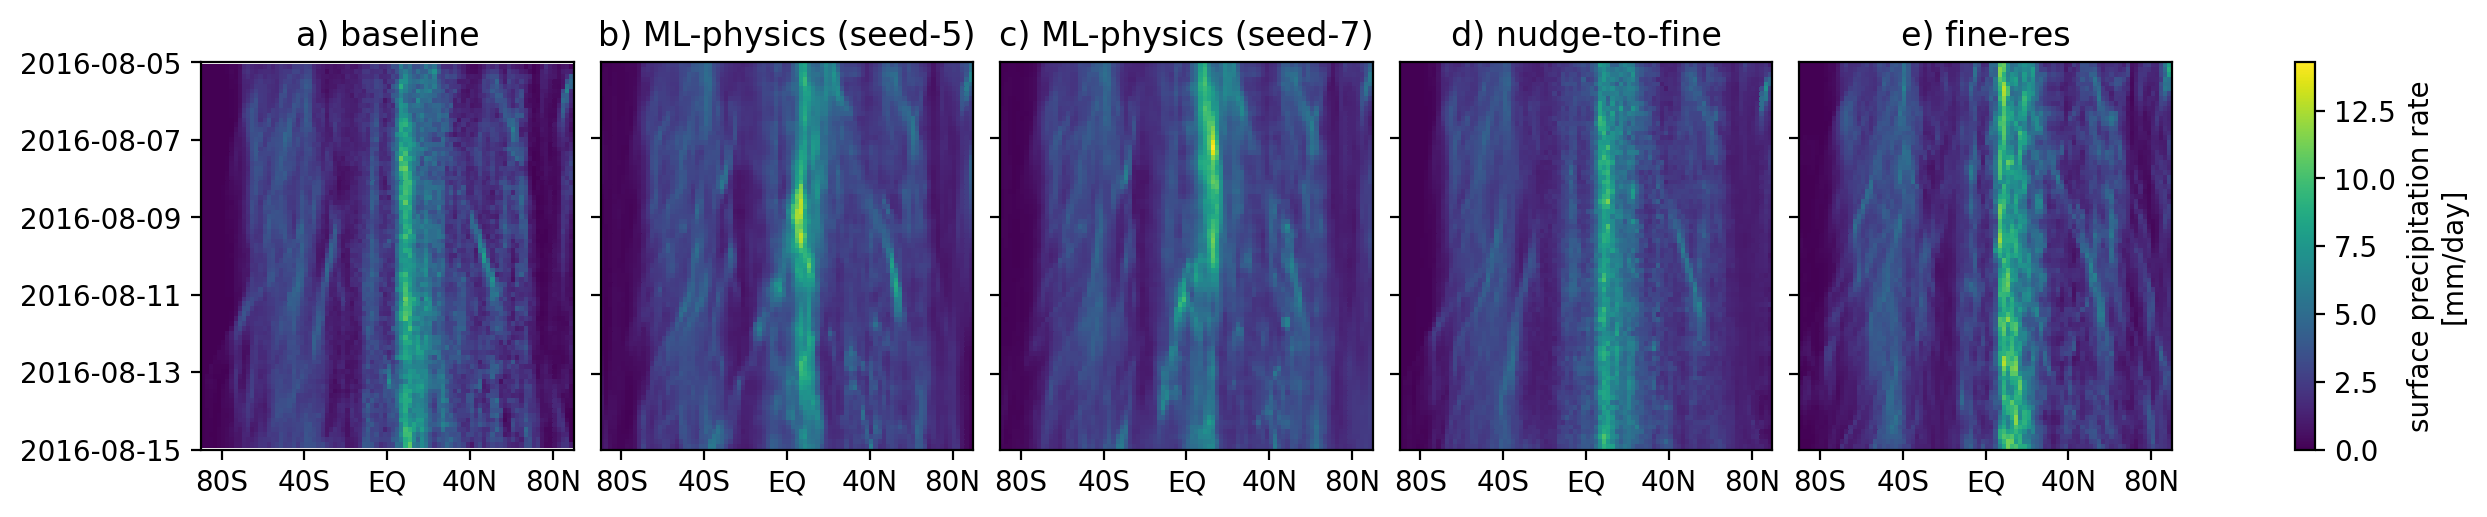

In [9]:
plotme = hov.sel(time=slice('2016-08-05', '2016-08-14T21:00:00'))
plotme.attrs['long_name'] = 'surface precipitation rate'
fg = plotme.plot(col='run', y='time', yincrease=False)
fg.fig.set_size_inches((13.5, 2.8))
fg.axes.flat[0].set_yticks([cftime.datetime(2016,8,d) for d in [5, 7, 9, 11, 13, 15]])
fg.axes.flat[0].set_ylabel('')
make_nice_labels(fg)

NameError: name 'timedelta' is not defined

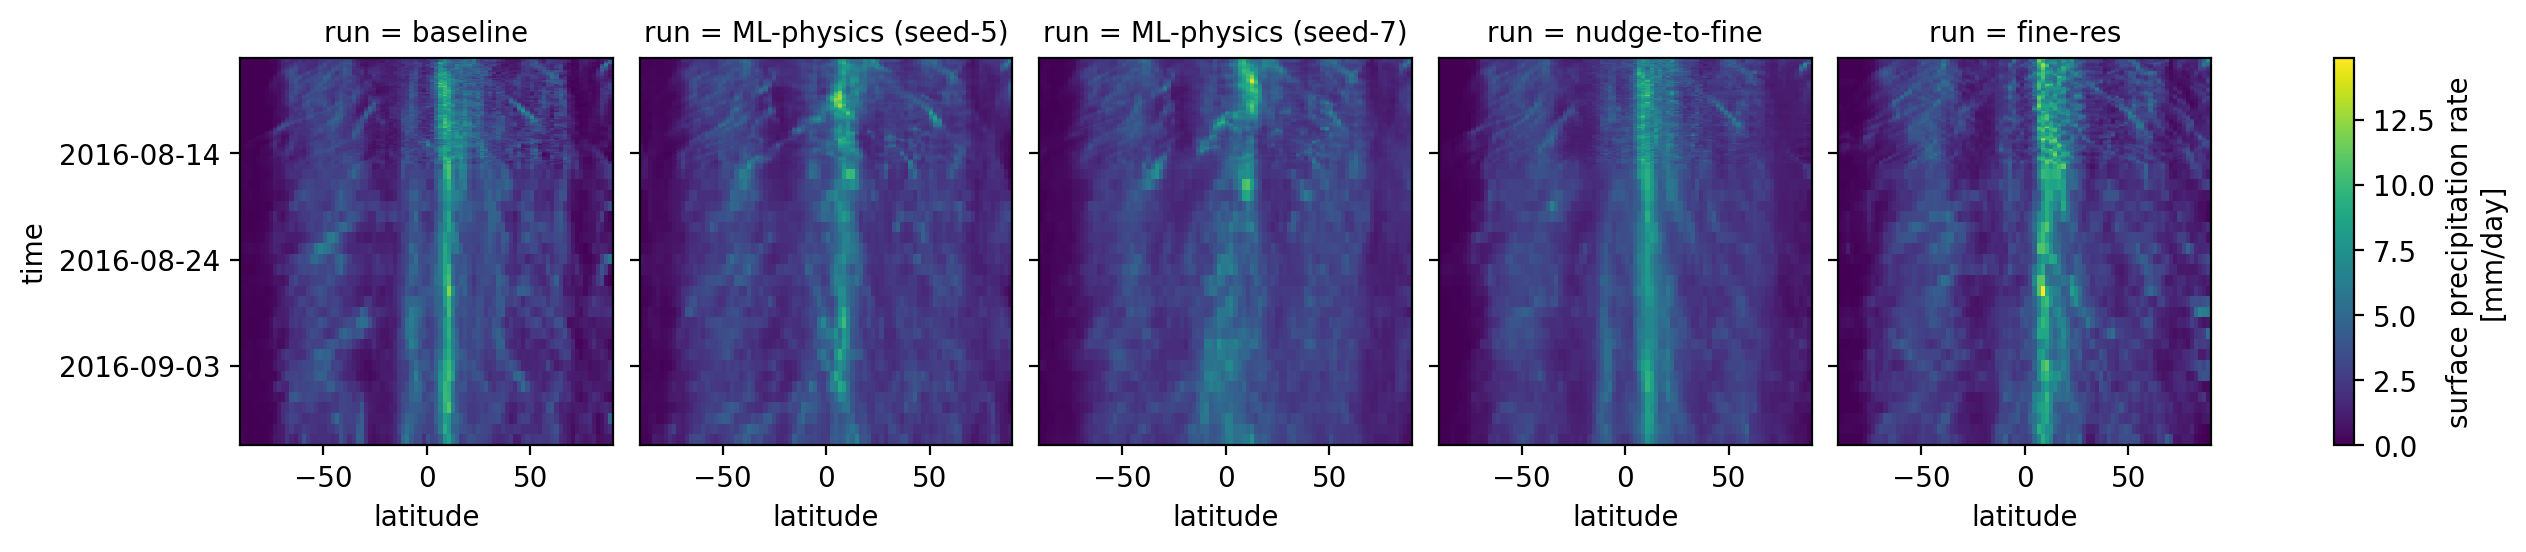

In [10]:
plotme = hov
plotme.attrs['long_name'] = 'surface precipitation rate'
fg = plotme.plot(col='run', y='time', yincrease=False)
fg.fig.set_size_inches((13.5, 2.8))
fg.axes.flat[0].set_yticks([cftime.datetime(2016,8,5) + td for td in [timedelta(days=x) for x in range(0, 36, 5)]])
fg.axes.flat[0].set_ylabel('')
make_nice_labels(fg)

In [ ]:
da = reduced_diags_only_seed5.air_temperature_pressure_level_zonal_bias
fg = da.plot.contourf(col='run', y='pressure', yincrease=False, vmin=-9.5, vmax=9.5, levels=20, cmap='RdBu_r')
make_nice_labels(fg)

In [ ]:
da = reduced_diags_only_seed5.specific_humidity_pressure_level_zonal_bias
fg = da.plot.contourf(col='run', y='pressure', yincrease=False, vmin=-2.125, vmax=2.125, levels=18, cmap='RdBu_r')
make_nice_labels(fg)

In [ ]:
da = reduced_diags_only_seed5.relative_humidity_pressure_level_zonal_bias
fg = da.plot.contourf(col='run', y='pressure', yincrease=False, vmin=-42, vmax=42, levels=22, cmap='RdBu_r', extend='both')
make_nice_labels(fg)